# TODO

- [x] filter for weird routes (over land, non-smooth, etc.)
- [ ] Check dependency of typical best cost and typical runtime on hyperparameters

## Filtering for broken routes by length

Let's cut away routes which are more than twice as long as the seed route.

In [1]:
from pathlib import Path
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import seaborn as sns
import shapely
from matplotlib import pyplot as plt

from ship_routing.app.routing import RoutingResult, RoutingLog
import msgpack
from tqdm.auto import tqdm

In [2]:
!ls results/

results_testing_19429596.msgpack


In [3]:
data_file = Path("results/results_testing_19429596.msgpack")

In [4]:
def load_results(msgpack_file: str, nitems: int = None) -> dict[str, RoutingResult]:
    """Load all results from msgpack file.

    Parameters
    ----------
    msgpack_file : str
        Path to msgpack file containing serialized results.
    nitems: int (optional)
        Restrict to first nitems items.

    Returns
    -------
    dict[str, RoutingResult]
        Dictionary mapping result keys to RoutingResult objects.
    """
    with open(msgpack_file, "rb") as f:
        raw_results = msgpack.unpack(f, raw=False)

    return {
        key: RoutingResult.from_msgpack(value) for key, value in tqdm(list(raw_results.items())[:nitems])
    }

In [5]:
results = load_results(data_file, 2000)

  0%|          | 0/40 [00:00<?, ?it/s]

In [6]:
len(results)

40

In [7]:
def remove_freak_results(routing_results_dict: dict = None):
    """There shold not be elite routes which are shorter than the original one."""
    return {
        k: v
        for k, v in tqdm(routing_results_dict.items())
        if not any([
            m.route.length_meters < v.seed_member.route.length_meters 
            for m in v.elite_population.members
        ])
    }

In [8]:
len(remove_freak_results(results))

  0%|          | 0/40 [00:00<?, ?it/s]

40

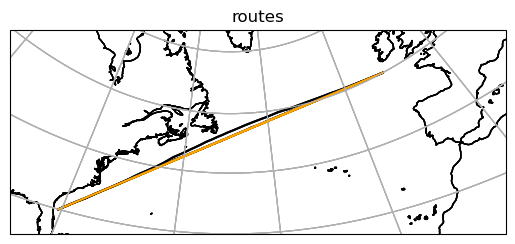

In [9]:
res_list = list(results.values())
ax = None
for _res in res_list[::10]:
    ax = _res.plot_routes(ax=ax)

In [10]:
def get_journey_params_df(routing_results_dict: dict = None):
    def _fix_waypoints(dct):
        dct['lon_waypoints'] = str(dct['lon_waypoints'])
        dct['lat_waypoints'] = str(dct['lat_waypoints'])
        return dct
        
    df = pd.concat(
        [
            pd.DataFrame(
                _fix_waypoints(rr.logs.config["journey"]),
                index=[
                    f,
                ],
            )
            for f, rr in routing_results_dict.items()
        ]
    ).add_prefix("journey_")
    df = df.assign(
        journey_lon_waypoints=df["journey_lon_waypoints"].astype("category"),
        journey_lat_waypoints=df["journey_lat_waypoints"].astype("category"),
    )
    df.index = df.index.rename("filename")
    return df

In [11]:
df_journey = get_journey_params_df(results)
df_journey

,journey_name,journey_lon_waypoints,journey_lat_waypoints,journey_time_start,journey_time_end,journey_speed_knots,journey_time_resolution_hours
filename,,,,,,,
result:2025-12-06T12-49-39.468_211f6eaa-362a-4e3c-8146-d84894034383,Backward-Route_testing,"[-11.0, -80.5]","[50.0, 30.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-06T12-46-44.908_97ee95ef-7040-446b-afe9-065ee2ff3e8c,Forward-Route_testing,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-06T12-46-45.010_91e5eabe-74a5-4c13-8847-455a3c1b5341,Forward-Route_testing,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-06T12-48-19.374_618f1dfa-9aaf-4557-ad19-221aa89ccf96,Backward-Route_testing,"[-11.0, -80.5]","[50.0, 30.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-06T12-46-43.513_3b4a7f7c-b717-40ea-976d-233ee834e078,Forward-Route_testing,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-06T12-46-49.074_7bf5ba1e-2660-4af3-8033-51682340be3f,Forward-Route_testing,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-06T12-48-21.347_453da2ef-1c74-481b-84b1-18c0b0043681,Backward-Route_testing,"[-11.0, -80.5]","[50.0, 30.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-06T12-46-31.196_866cbf62-7404-48bd-a23c-db48083511a3,Forward-Route_testing,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-06T12-46-43.991_7b1ec738-ca30-49c4-bb3f-09ab4f4df62e,Forward-Route_testing,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0


In [12]:
def get_hyper_params_df(routing_results_dict: dict = None):
    df = pd.concat(
        [
            pd.DataFrame(
                rr.logs.config["hyper"],
                index=[
                    f,
                ],
            )
            for f, rr in routing_results_dict.items()
        ]
    ).add_prefix("hyper_")
    df = df.assign(
        hyper_crossover_strategy=df["hyper_crossover_strategy"].astype("category")
    )
    df.index = df.index.rename("filename")
    return df

In [13]:
df_params = pd.merge(
    get_hyper_params_df(results), 
    get_journey_params_df(results), 
    left_index=True, 
    right_index=True,
)
df_params

,hyper_population_size,hyper_random_seed,hyper_selection_acceptance_rate_warmup,hyper_mutation_width_fraction_warmup,hyper_mutation_displacement_fraction_warmup,hyper_generations,hyper_offspring_size,hyper_crossover_rounds,hyper_selection_quantile,hyper_selection_acceptance_rate,...,hyper_distance_increment,hyper_num_workers,hyper_executor_type,journey_name,journey_lon_waypoints,journey_lat_waypoints,journey_time_start,journey_time_end,journey_speed_knots,journey_time_resolution_hours
filename,,,,,,,,,,,,,,,,,,,,,
result:2025-12-06T12-49-39.468_211f6eaa-362a-4e3c-8146-d84894034383,4,863300645,0.3,0.9,0.25,1,4,0,0.10,0.25,...,10000.0,4,process,Backward-Route_testing,"[-11.0, -80.5]","[50.0, 30.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-06T12-46-44.908_97ee95ef-7040-446b-afe9-065ee2ff3e8c,8,901685872,0.3,0.5,0.10,1,8,1,0.10,0.25,...,10000.0,4,process,Forward-Route_testing,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-06T12-46-45.010_91e5eabe-74a5-4c13-8847-455a3c1b5341,4,4050273997,0.3,0.9,0.25,1,4,0,0.25,0.25,...,10000.0,4,process,Forward-Route_testing,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-06T12-48-19.374_618f1dfa-9aaf-4557-ad19-221aa89ccf96,4,1929853370,0.3,0.5,0.10,1,4,1,0.10,0.25,...,10000.0,4,process,Backward-Route_testing,"[-11.0, -80.5]","[50.0, 30.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-06T12-46-43.513_3b4a7f7c-b717-40ea-976d-233ee834e078,8,1521811283,0.3,0.5,0.10,1,8,1,0.10,0.00,...,10000.0,4,process,Forward-Route_testing,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-06T12-46-49.074_7bf5ba1e-2660-4af3-8033-51682340be3f,4,3137525904,0.3,0.5,0.25,1,4,1,0.25,0.25,...,10000.0,4,process,Forward-Route_testing,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-06T12-48-21.347_453da2ef-1c74-481b-84b1-18c0b0043681,4,3126771746,0.3,0.5,0.25,1,4,1,0.10,0.00,...,10000.0,4,process,Backward-Route_testing,"[-11.0, -80.5]","[50.0, 30.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-06T12-46-31.196_866cbf62-7404-48bd-a23c-db48083511a3,8,4141992466,0.3,0.9,0.25,1,8,0,0.10,0.25,...,10000.0,4,process,Forward-Route_testing,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-06T12-46-43.991_7b1ec738-ca30-49c4-bb3f-09ab4f4df62e,4,4276206606,0.3,0.5,0.10,2,4,1,0.10,0.00,...,10000.0,4,process,Forward-Route_testing,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0


In [14]:
df_params.describe().T

,count,mean,std,min,25%,50%,75%,max
hyper_population_size,40.0,6.100000e+00,2.022945e+00,4.0,4.000000e+00,8.000000e+00,8.000000e+00,8.000000e+00
hyper_random_seed,40.0,2.541435e+09,1.381144e+09,143088874.0,1.109938e+09,3.058791e+09,3.873118e+09,4.276207e+09
hyper_selection_acceptance_rate_warmup,40.0,3.000000e-01,0.000000e+00,0.3,3.000000e-01,3.000000e-01,3.000000e-01,3.000000e-01
hyper_mutation_width_fraction_warmup,40.0,6.900000e-01,2.022945e-01,0.5,5.000000e-01,5.000000e-01,9.000000e-01,9.000000e-01
hyper_mutation_displacement_fraction_warmup,40.0,1.712500e-01,7.586045e-02,0.1,1.000000e-01,1.000000e-01,2.500000e-01,2.500000e-01
hyper_generations,40.0,1.475000e+00,5.057363e-01,1.0,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00
hyper_offspring_size,40.0,6.100000e+00,2.022945e+00,4.0,4.000000e+00,8.000000e+00,8.000000e+00,8.000000e+00
hyper_crossover_rounds,40.0,5.500000e-01,5.038315e-01,0.0,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
hyper_selection_quantile,40.0,1.637500e-01,7.509609e-02,0.1,1.000000e-01,1.000000e-01,2.500000e-01,2.500000e-01
hyper_selection_acceptance_rate,40.0,1.375000e-01,1.259579e-01,0.0,0.000000e+00,2.500000e-01,2.500000e-01,2.500000e-01


In [15]:
def get_runtime(routing_results_dict: dict = None):
    _records = []
    for f, rr in routing_results_dict.items():
        _records.extend(
            [
                {
                    "filename": f,
                    "runtime": rr.logs.to_dataframe().timestamp.max()
                    - rr.logs.to_dataframe().timestamp.min(),
                }
            ]
        )
    df = pd.DataFrame.from_records(_records).set_index("filename")
    df = df.assign(runtime_seconds=df.runtime.dt.total_seconds())
    return df

In [16]:
df_runtime = get_runtime(results)
df_runtime

,runtime,runtime_seconds
filename,,
result:2025-12-06T12-49-39.468_211f6eaa-362a-4e3c-8146-d84894034383,0 days 00:01:04,64.0
result:2025-12-06T12-46-44.908_97ee95ef-7040-446b-afe9-065ee2ff3e8c,0 days 00:01:15,75.0
result:2025-12-06T12-46-45.010_91e5eabe-74a5-4c13-8847-455a3c1b5341,0 days 00:01:12,72.0
result:2025-12-06T12-48-19.374_618f1dfa-9aaf-4557-ad19-221aa89ccf96,0 days 00:01:11,71.0
result:2025-12-06T12-46-43.513_3b4a7f7c-b717-40ea-976d-233ee834e078,0 days 00:01:17,77.0
result:2025-12-06T12-46-49.074_7bf5ba1e-2660-4af3-8033-51682340be3f,0 days 00:01:24,84.0
result:2025-12-06T12-48-21.347_453da2ef-1c74-481b-84b1-18c0b0043681,0 days 00:01:13,73.0
result:2025-12-06T12-46-31.196_866cbf62-7404-48bd-a23c-db48083511a3,0 days 00:01:10,70.0
result:2025-12-06T12-46-43.991_7b1ec738-ca30-49c4-bb3f-09ab4f4df62e,0 days 00:01:25,85.0


In [17]:
df_runtime.groupby(df_params.journey_lat_waypoints).runtime_seconds.describe()

/var/folders/w1/m9mm9h9167z_gcfzfffr0rgsh6j6kj/T/ipykernel_41106/3546377973.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_runtime.groupby(df_params.journey_lat_waypoints).runtime_seconds.describe()


,count,mean,std,min,25%,50%,75%,max
journey_lat_waypoints,,,,,,,,
"[30.0, 50.0]",20.0,75.75,7.144192,63.0,70.75,75.5,80.00,93.0
"[50.0, 30.0]",20.0,74.65,7.169196,63.0,71.75,74.0,77.25,93.0


In [18]:
def get_elite(routing_results_dict: dict = None):
    _records = []
    for f, rr in routing_results_dict.items():
        seed_member = rr.seed_member
        _records.extend(
            [
                {
                    "filename": f,
                    "n_elite": n,
                    "elite_length_meters": m.route.length_meters,
                    "elite_length_relative": m.route.length_meters / seed_member.route.length_meters,
                    "elite_cost_absolute": m.cost,
                    "elite_cost_relative": m.cost / seed_member.cost,
                }
                for n, m in enumerate(rr.elite_population.members)
            ]
        )
    return pd.DataFrame.from_records(_records).set_index("filename")

In [19]:
df_elite = get_elite(results)
df_elite

,n_elite,elite_length_meters,elite_length_relative,elite_cost_absolute,elite_cost_relative
filename,,,,,
result:2025-12-06T12-49-39.468_211f6eaa-362a-4e3c-8146-d84894034383,0,6.095818e+06,1.000406,9.541289e+12,0.988658
result:2025-12-06T12-49-39.468_211f6eaa-362a-4e3c-8146-d84894034383,1,6.095818e+06,1.000406,9.541289e+12,0.988658
result:2025-12-06T12-46-44.908_97ee95ef-7040-446b-afe9-065ee2ff3e8c,0,6.093342e+06,1.000000,NaN,NaN
result:2025-12-06T12-46-45.010_91e5eabe-74a5-4c13-8847-455a3c1b5341,0,6.093342e+06,1.000000,NaN,NaN
result:2025-12-06T12-48-19.374_618f1dfa-9aaf-4557-ad19-221aa89ccf96,0,6.095817e+06,1.000406,9.542044e+12,0.988736
...,...,...,...,...,...
result:2025-12-06T12-45-30.519_4fb48b17-effa-40d0-b01c-ca2909b2ed82,0,6.095122e+06,1.000292,1.051757e+13,0.985836
result:2025-12-06T12-45-30.519_4fb48b17-effa-40d0-b01c-ca2909b2ed82,1,6.095122e+06,1.000292,1.051757e+13,0.985836
result:2025-12-06T12-45-24.038_60619110-52c4-49ad-bc2f-4f66f763d4bf,0,6.203072e+06,1.018008,1.012683e+13,0.949212


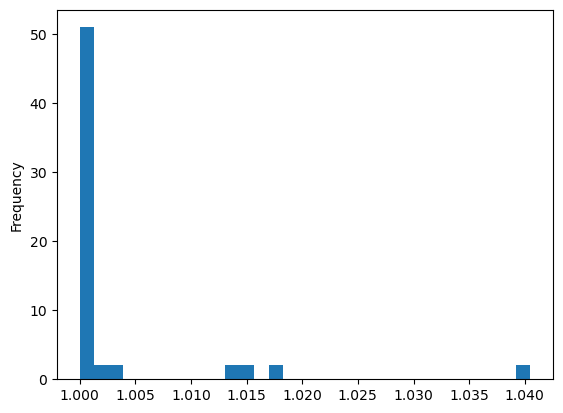

In [20]:
df_elite.elite_length_relative.plot.hist(bins=31);

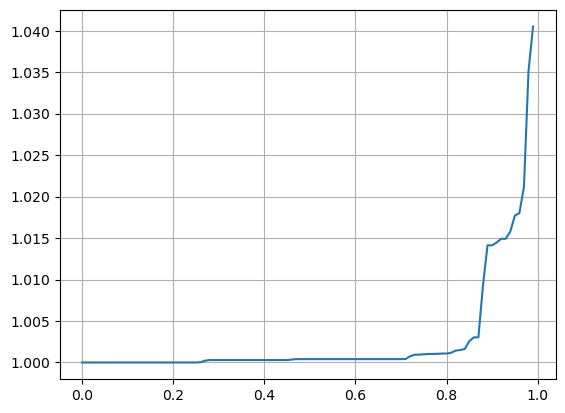

In [21]:
ax = df_elite.elite_length_relative.quantile(np.arange(0, 1, 0.01)).plot(logy=False, grid=True);

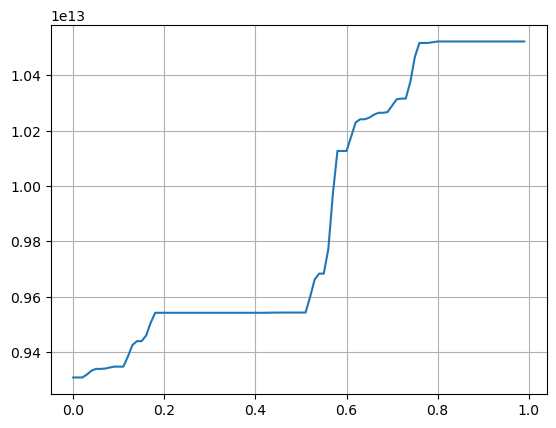

In [22]:
ax = df_elite.elite_cost_absolute.quantile(np.arange(0, 1, 0.01)).plot(logy=False, grid=True);

In [23]:
df_merged = (
    df_params
    .merge(df_elite, left_index=True, right_index=True, how="inner")
    .merge(df_runtime, left_index=True, right_index=True, how="inner")
)
df_merged

,hyper_population_size,hyper_random_seed,hyper_selection_acceptance_rate_warmup,hyper_mutation_width_fraction_warmup,hyper_mutation_displacement_fraction_warmup,hyper_generations,hyper_offspring_size,hyper_crossover_rounds,hyper_selection_quantile,hyper_selection_acceptance_rate,...,journey_time_end,journey_speed_knots,journey_time_resolution_hours,n_elite,elite_length_meters,elite_length_relative,elite_cost_absolute,elite_cost_relative,runtime,runtime_seconds
filename,,,,,,,,,,,,,,,,,,,,,
result:2025-12-06T12-49-39.468_211f6eaa-362a-4e3c-8146-d84894034383,4,863300645,0.3,0.9,0.25,1,4,0,0.10,0.25,...,2021-01-14T17:00:51,10.0,6.0,0,6.095818e+06,1.000406,9.541289e+12,0.988658,0 days 00:01:04,64.0
result:2025-12-06T12-49-39.468_211f6eaa-362a-4e3c-8146-d84894034383,4,863300645,0.3,0.9,0.25,1,4,0,0.10,0.25,...,2021-01-14T17:00:51,10.0,6.0,1,6.095818e+06,1.000406,9.541289e+12,0.988658,0 days 00:01:04,64.0
result:2025-12-06T12-46-44.908_97ee95ef-7040-446b-afe9-065ee2ff3e8c,8,901685872,0.3,0.5,0.10,1,8,1,0.10,0.25,...,2021-01-14T17:00:51,10.0,6.0,0,6.093342e+06,1.000000,NaN,NaN,0 days 00:01:15,75.0
result:2025-12-06T12-46-45.010_91e5eabe-74a5-4c13-8847-455a3c1b5341,4,4050273997,0.3,0.9,0.25,1,4,0,0.25,0.25,...,2021-01-14T17:00:51,10.0,6.0,0,6.093342e+06,1.000000,NaN,NaN,0 days 00:01:12,72.0
result:2025-12-06T12-48-19.374_618f1dfa-9aaf-4557-ad19-221aa89ccf96,4,1929853370,0.3,0.5,0.10,1,4,1,0.10,0.25,...,2021-01-14T17:00:51,10.0,6.0,0,6.095817e+06,1.000406,9.542044e+12,0.988736,0 days 00:01:11,71.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
result:2025-12-06T12-45-30.519_4fb48b17-effa-40d0-b01c-ca2909b2ed82,4,2773662967,0.3,0.9,0.25,2,4,1,0.10,0.00,...,2021-01-14T17:00:51,10.0,6.0,0,6.095122e+06,1.000292,1.051757e+13,0.985836,0 days 00:01:20,80.0
result:2025-12-06T12-45-30.519_4fb48b17-effa-40d0-b01c-ca2909b2ed82,4,2773662967,0.3,0.9,0.25,2,4,1,0.10,0.00,...,2021-01-14T17:00:51,10.0,6.0,1,6.095122e+06,1.000292,1.051757e+13,0.985836,0 days 00:01:20,80.0
result:2025-12-06T12-45-24.038_60619110-52c4-49ad-bc2f-4f66f763d4bf,8,678473240,0.3,0.5,0.25,2,8,0,0.25,0.25,...,2021-01-14T17:00:51,10.0,6.0,0,6.203072e+06,1.018008,1.012683e+13,0.949212,0 days 00:01:14,74.0


In [24]:
df_merged.columns

Index(['hyper_population_size', 'hyper_random_seed',
       'hyper_selection_acceptance_rate_warmup',
       'hyper_mutation_width_fraction_warmup',
       'hyper_mutation_displacement_fraction_warmup', 'hyper_generations',
       'hyper_offspring_size', 'hyper_crossover_rounds',
       'hyper_selection_quantile', 'hyper_selection_acceptance_rate',
       'hyper_mutation_width_fraction', 'hyper_mutation_displacement_fraction',
       'hyper_mutation_iterations', 'hyper_crossover_strategy',
       'hyper_ignore_hazards', 'hyper_num_elites', 'hyper_gd_iterations',
       'hyper_learning_rate_time', 'hyper_learning_rate_space',
       'hyper_time_increment', 'hyper_distance_increment', 'hyper_num_workers',
       'hyper_executor_type', 'journey_name', 'journey_lon_waypoints',
       'journey_lat_waypoints', 'journey_time_start', 'journey_time_end',
       'journey_speed_knots', 'journey_time_resolution_hours', 'n_elite',
       'elite_length_meters', 'elite_length_relative', 'elite_cost_a

In [25]:
df_analysis = (
  df_merged
  .groupby(level=0)  # group by filename
  .agg({
      'runtime_seconds': 'first',  # same for all rows
      **{col: 'first' for col in df_merged.columns if col.startswith('hyper_') or col.startswith('journey_')},
      **{col: 'first' for col in df_merged.columns if col.startswith('elite_')}
  })
)
df_analysis

,runtime_seconds,hyper_population_size,hyper_random_seed,hyper_selection_acceptance_rate_warmup,hyper_mutation_width_fraction_warmup,hyper_mutation_displacement_fraction_warmup,hyper_generations,hyper_offspring_size,hyper_crossover_rounds,hyper_selection_quantile,...,journey_lon_waypoints,journey_lat_waypoints,journey_time_start,journey_time_end,journey_speed_knots,journey_time_resolution_hours,elite_length_meters,elite_length_relative,elite_cost_absolute,elite_cost_relative
filename,,,,,,,,,,,,,,,,,,,,,
result:2025-12-06T12-45-16.712_14d090f6-ceac-44c9-801c-91fafe71b254,66.0,4,4157335714,0.3,0.5,0.25,2,4,0,0.25,...,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0,6.095121e+06,1.000292,1.052307e+13,0.986352
result:2025-12-06T12-45-19.126_979205e8-a193-4cd8-b031-10fef9049227,69.0,8,3346232728,0.3,0.5,0.25,1,8,0,0.25,...,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0,6.095121e+06,1.000292,1.052307e+13,0.986352
result:2025-12-06T12-45-19.548_ed14766b-bbee-4f24-b70c-27bfd07e9500,69.0,8,1124897713,0.3,0.5,0.10,1,8,0,0.10,...,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0,6.184194e+06,1.014910,1.031634e+13,0.966974
result:2025-12-06T12-45-21.425_991b511f-70f3-42ed-a40c-40550b396ebd,71.0,8,2139997647,0.3,0.5,0.10,2,8,0,0.25,...,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0,6.095121e+06,1.000292,1.052307e+13,0.986352
result:2025-12-06T12-45-23.151_e8022ce1-dfb7-460c-a1b9-4806017af4ec,73.0,4,3043431243,0.3,0.5,0.10,2,4,0,0.25,...,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0,6.093342e+06,1.000000,NaN,NaN
result:2025-12-06T12-45-24.038_60619110-52c4-49ad-bc2f-4f66f763d4bf,74.0,8,678473240,0.3,0.5,0.25,2,8,0,0.25,...,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0,6.203072e+06,1.018008,1.012683e+13,0.949212
result:2025-12-06T12-45-26.837_e07fbfcf-bd5d-4cd9-a2ee-5ef9624d1c17,76.0,4,3977110810,0.3,0.5,0.10,2,4,1,0.25,...,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0,6.093342e+06,1.000000,NaN,NaN
result:2025-12-06T12-45-29.856_4210be7b-2d52-47d7-85da-f1f88d33862d,79.0,8,4001893168,0.3,0.5,0.25,1,8,1,0.10,...,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0,6.095121e+06,1.000292,1.052307e+13,0.986352
result:2025-12-06T12-45-30.519_4fb48b17-effa-40d0-b01c-ca2909b2ed82,80.0,4,2773662967,0.3,0.9,0.25,2,4,1,0.10,...,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0,6.095122e+06,1.000292,1.051757e+13,0.985836


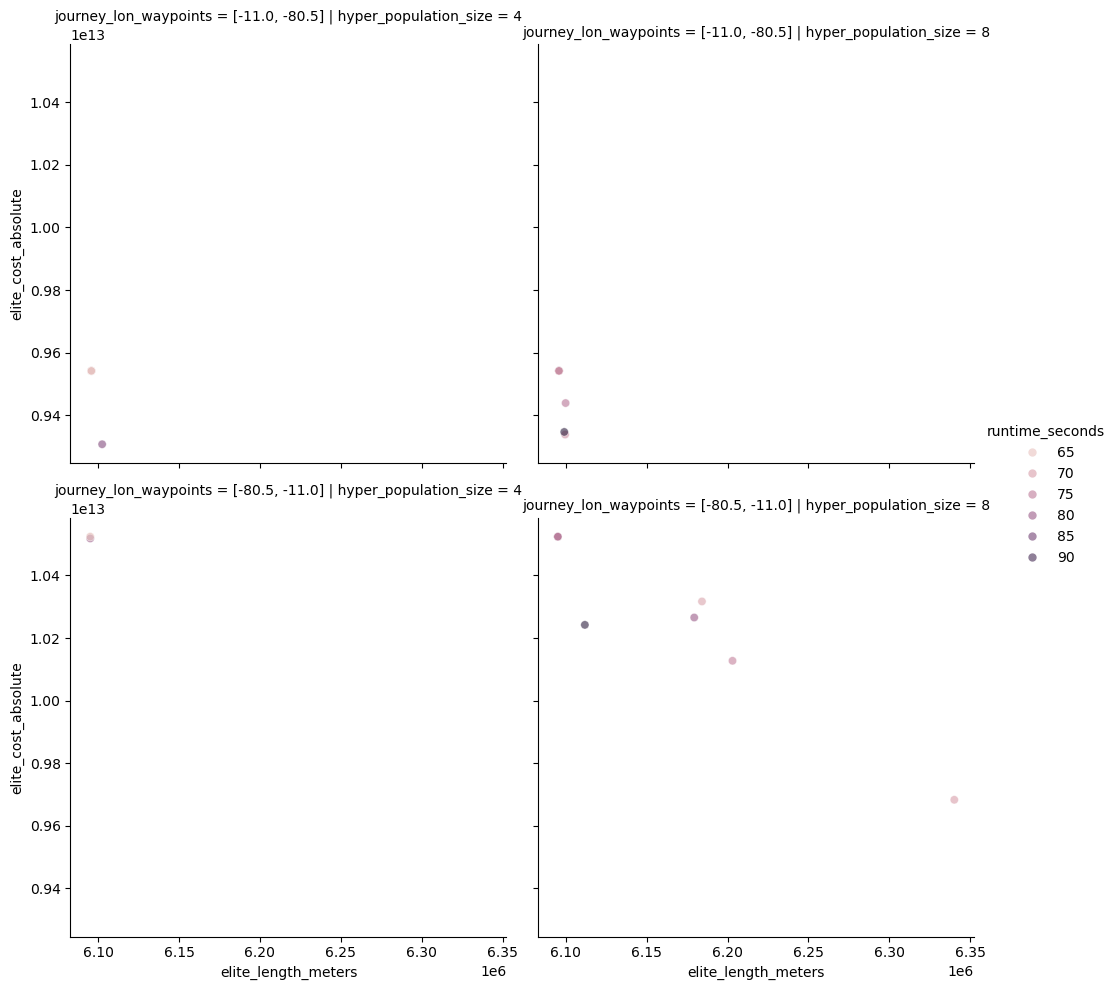

In [26]:
sns.relplot(
    data=df_analysis,
    x='elite_length_meters',
    y='elite_cost_absolute',
    hue='runtime_seconds',
    col='hyper_population_size',
    row='journey_lon_waypoints',
    alpha=0.6,
)

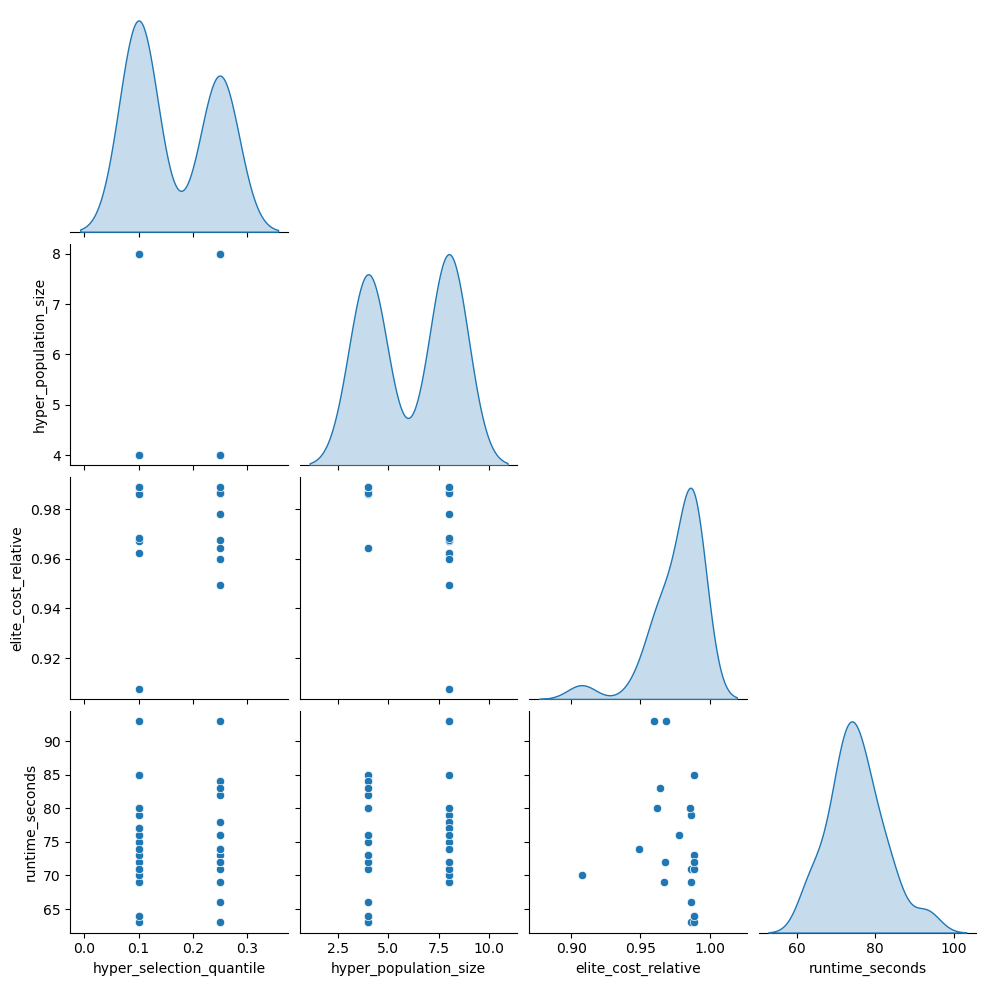

In [27]:
# Select key hyperparameters
key_vars = [
  'hyper_selection_quantile',
  'hyper_population_size',
  'elite_cost_relative',
  'runtime_seconds'
]
sns.pairplot(df_analysis[key_vars], diag_kind='kde', corner=True)

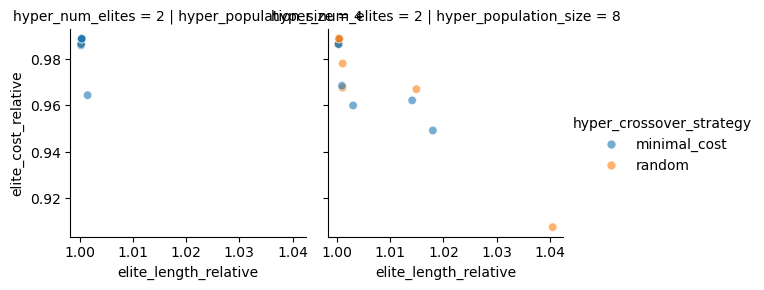

In [28]:
 sns.relplot(
      data=df_analysis,
      x='elite_length_relative',
      y='elite_cost_relative',
      hue='hyper_crossover_strategy',
      col='hyper_population_size',
      row='hyper_num_elites',
      kind='scatter',
      alpha=0.6,
      height=3
  )

/var/folders/w1/m9mm9h9167z_gcfzfffr0rgsh6j6kj/T/ipykernel_41106/122762472.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['hyper_population_size', 'hyper_generations', 'hyper_crossover_strategy'])


<Axes: xlabel='hyper_population_size', ylabel='hyper_generations-hyper_crossover_strategy'>

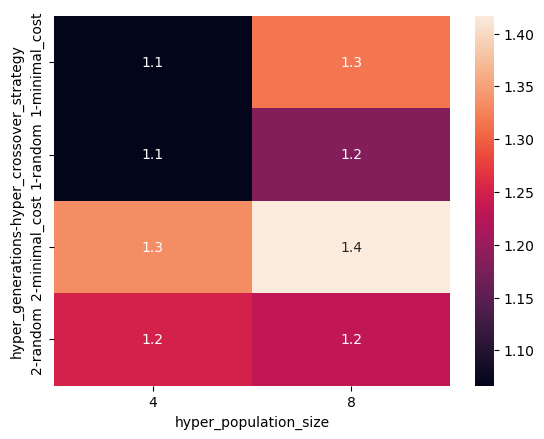

In [29]:
sns.heatmap(
    df_merged
    .groupby(['hyper_population_size', 'hyper_generations', 'hyper_crossover_strategy'])
    .runtime
    .median()
    .dt.total_seconds()
    .unstack(0) / 60,
    annot=True
)

/var/folders/w1/m9mm9h9167z_gcfzfffr0rgsh6j6kj/T/ipykernel_41106/3833727738.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['journey_lon_waypoints', 'hyper_population_size', 'hyper_generations'])


<Axes: xlabel='journey_lon_waypoints', ylabel='hyper_population_size-hyper_generations'>

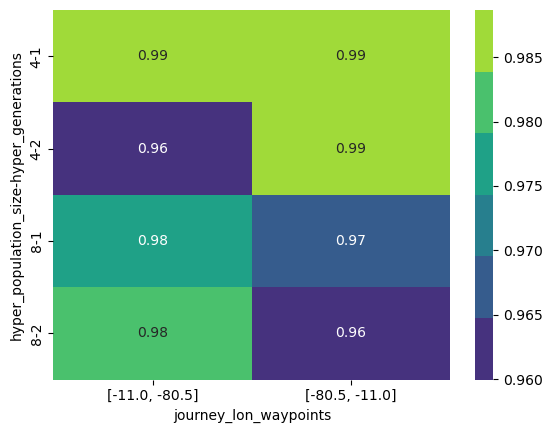

In [30]:
sns.heatmap(
    df_merged
    .groupby(['journey_lon_waypoints', 'hyper_population_size', 'hyper_generations'])
    .elite_cost_relative
    # .quantile(np.linspace(0, 1, 11))
    .median()
    .unstack(0),
    annot=True,
    cmap=sns.color_palette("viridis")
)

/var/folders/w1/m9mm9h9167z_gcfzfffr0rgsh6j6kj/T/ipykernel_41106/3988838336.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['journey_lon_waypoints', 'hyper_population_size', 'hyper_generations'])


<Axes: ylabel='journey_lon_waypoints-hyper_population_size-hyper_generations'>

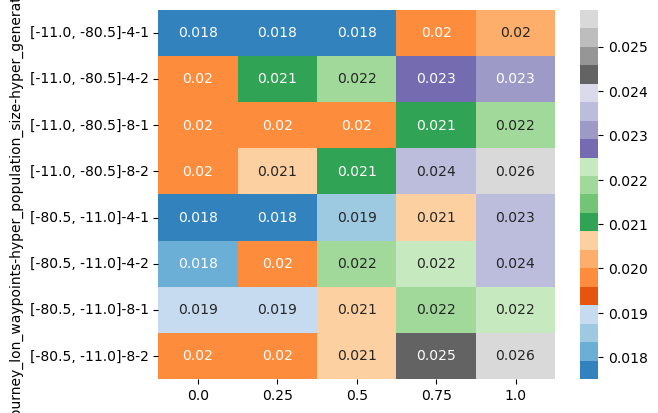

In [31]:
sns.heatmap(
    (df_merged
    .groupby(['journey_lon_waypoints', 'hyper_population_size', 'hyper_generations'])
    .runtime_seconds
    .quantile(np.linspace(0, 1, 5)) / 3600)
    .unstack(-1),
    annot=True,
    cmap=sns.color_palette("tab20c")
)

<GeoAxes: title={'center': 'routes, Gnomonic proj'}>

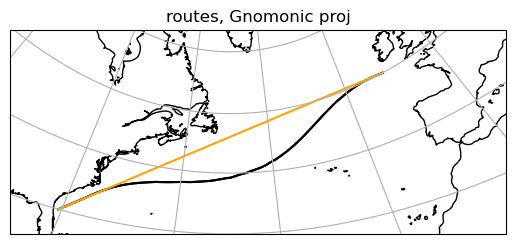

In [33]:
results[df_elite.index[df_elite.elite_cost_relative.argmin()]].plot_routes()